- 在TS_1中，我们得到了如下平稳的收益率时间序列(In TS_1, we get the following stable yield time series)

In [1]:
from jqdatasdk import *
import arch
import numpy as np
import matplotlib.pyplot as plt

auth('13241809053','809053')
is_auth = is_auth()

from jqdatasdk import *
import matplotlib.pyplot as plt
auth('13241809053','809053')
is_auth = is_auth()

price = get_price("000001.XSHG", start_date="2015-1-1", end_date="2019-12-31", frequency='daily')['close']
returns = price.pct_change().dropna()

train_price = get_price("000001.XSHG", start_date="2015-1-1", end_date="2019-12-24", frequency='daily')['close']
train_returns = train_price.pct_change().dropna()

test_price = get_price("000001.XSHG", start_date="2019-12-24", end_date="2019-12-31", frequency='daily')['close']
test_returns = test_price.pct_change().dropna()

auth success 


## 1. 画自相关系数（ACF）和偏自相关系数（PACF）的图  (Plot autocorrelation coefficient (ACF) and partial autocorrelation coefficient (PACF))

Text(0.5,1,'PACF')

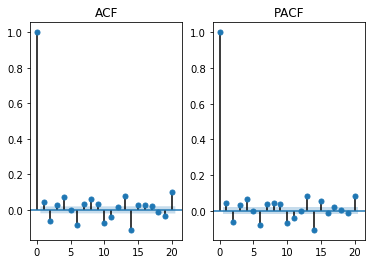

In [2]:
import statsmodels.tsa.api as smt

size = (1,2)
acf_ax = plt.subplot2grid(size, (0, 0))
pacf_ax = plt.subplot2grid(size, (0, 1))
    
smt.graphics.plot_acf(train_returns, lags=20, ax=acf_ax, alpha=0.5)
acf_ax.set_title("ACF")  
smt.graphics.plot_pacf(train_returns, lags=20, ax=pacf_ax, alpha=0.5)
pacf_ax.set_title("PACF")

## 2. 模型定阶，参数估计，显著性检验，模型优化
## Model ordering, parameter estimation, significance test, model optimization

### 尝试ARMA(3,2)
- 参数通过显著性检验(Parameter passed significance test)
- 还可以尝试MA(1),AR(1),AR(2),ARMA(1,1)等多种模型，比较AIC和BIC的值(You can also try MA (1), AR (1), AR (2), ARMA (1,1) and other models to compare the values of AIC and BIC)

In [3]:
import statsmodels.api as sm
order = (3,2)
train_ar_result = sm.tsa.ARMA(train_returns,order).fit()
print(train_ar_result.summary())

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1213
Model:                     ARMA(3, 2)   Log Likelihood                3398.997
Method:                       css-mle   S.D. of innovations              0.015
Date:                Thu, 30 Jan 2020   AIC                          -6783.994
Time:                        02:54:47   BIC                          -6748.288
Sample:                             0   HQIC                         -6770.551
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.032e-05      0.000      0.046      0.964      -0.001       0.001
ar.L1.close     0.2525      0.038      6.622      0.000       0.178       0.327
ar.L2.close    -0.9704      0.018    -54.561    

- 对残差进行DW自相关检验，确认残差为纯随机序列(Perform a DW autocorrelation test on the residuals to confirm that the residuals are purely random sequences)
- 残差图显示异方差性(Residual plot showing heteroscedasticity)

1.9100244383084863


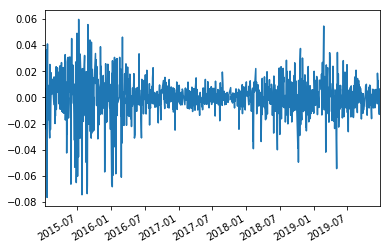

In [4]:
import statsmodels.api as sm
print(sm.stats.durbin_watson(train_returns))
train_ar_result.resid.plot()

### AR自动定阶(AR automatic ranking)
- 15阶，太大了(Order 15 is too big)

In [7]:
parameter = smt.AR(train_returns.values).fit(maxlag=30, ic='aic', trend='nc')
best_order = smt.AR(train_returns.values).select_order(maxlag=30, ic='aic', trend='nc')
print("模型参数parameter： ", parameter)
print("最佳滞后阶数best order： ",best_order)

模型参数parameter：  <statsmodels.tsa.ar_model.ARResultsWrapper object at 0x0000017F0569B9B0>
最佳滞后阶数best order：  15


### 利用AIC自动定阶，改成BIC也可以(Using AIC automatic ordering, you can also change to BIC)
- 结论是ARMA(5,5)，并不一定合适。因为可能它的参数无法通过检验，只能作为定阶参考(The conclusion is that ARMA (5,5) is not necessarily appropriate. Because its parameters may not pass the test, it can only be used as a reference for ordering)

In [6]:
train_results = smt.arma_order_select_ic(train_returns.values, ic=['aic'], trend= 'nc', max_ar= 5, max_ma= 5)
print( 'AIC', train_results.aic_min_order)

D:\anaconda\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
D:\anaconda\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
D:\anaconda\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which wi

AIC (4, 5)


#### 残差图显示集群效应（残差时大时小），估计存在异方差性，见TS_3 (Residual plots show cluster effects (large when small and small when residual), and heteroscedasticity is estimated, see TS_3)